# Example 7 - Linear RNN

March 6, 2022

The goal here is to train a RNN that is _linear_, i.e. $f(x)=x$. This doesn't seem to be difficult for RFLO, but _does_ lead to problems with REINFORCE

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE

from utils.plotting import plot_trained_trajectories

In [3]:
# define f and df

def f_linear(x):
    return x

def df_linear(x):
    return 1

### Train RNN on four targets using RFLO

In [4]:
trial_duration = 20
n_in=4
frac_on = 0.1

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

## 1. Training linear network with RFLO `w_rec` only, with velocity transformation 

23it [00:00, 229.09it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.1
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 1
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7fb6d82eef30>


500it [00:01, 476.80it/s]


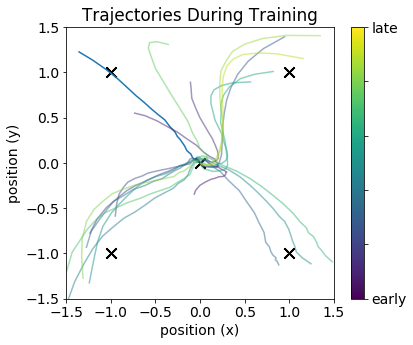

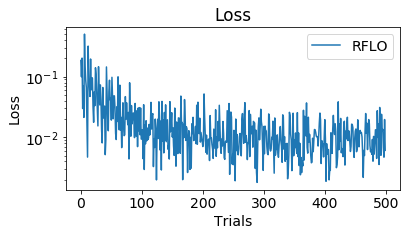

In [34]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.1,sig_out=0.1,
               velocity_transform=True, tau_vel = 1, dt_vel = 0.1,
               rng=np.random.RandomState(1))

params.print_params()

# Initialize RNN
net = RNN(params,f=f_linear,df=df_linear)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_rec'],online=False) 


sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=[], plot=True, plot_freq=25)


Note that we have not trained `w_out` at all, and are therefore forced to drive activity in a way that takes advantage of the readout matrix. We can also plot the trained trajectories

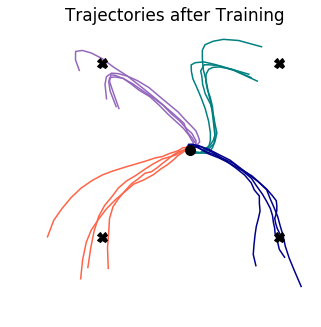

In [35]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])


## 2. Train Linear network with REINFORCE

This can be pretty unstable, and I have not found hyperparameters that lead to successful execution of the task. In order for the algorithm to work, it needs _noise_. However, too much noise can lead to nonstable solutions.

In [5]:
trial_duration = 20
n_in=4
frac_on = 0.5

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

21it [00:00, 198.13it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.01
sig_rec: 0.01
sig_out: 0.1
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 2
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7fa4c2a06870>


5000it [00:15, 313.23it/s]


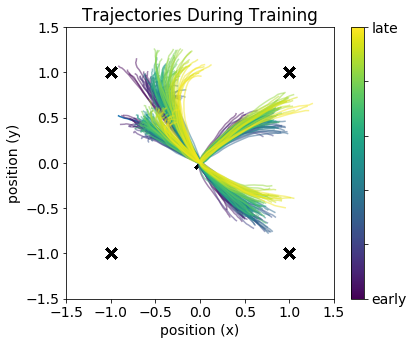

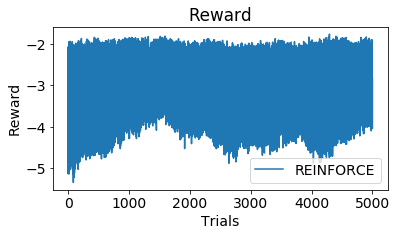

In [25]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.01,sig_rec=0.01,sig_out=0.1,
               velocity_transform=True, tau_vel = 2, dt_vel = 0.1,
               rng=np.random.RandomState(1))

# Initialize RNN
params.print_params()
net = RNN(params,f=f_linear, df=df_linear)
net.set_weights(w_rec=0.1*params.rng.randn(params.n_rec, params.n_rec)/params.n_rec**0.5) # set to be small, for stability



# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
reinforce = REINFORCE(net,apply_to=['w_rec'],online=False,tau_reward=5) 
#rflo = RFLO(net,apply_to=['w_out'],online=True) 

#sim.run_session(n_trials=50, tasks=[task1,task2], learn_alg=[rflo], probe_types=['pos','loss'], plot=True, plot_freq=1)

#sim.run_session(n_trials=2000, tasks=[task1], learn_alg=[reinforce], probe_types=['pos','reward'], plot=True, plot_freq=100)
#sim.run_session(n_trials=4000, tasks=[task1,task2], learn_alg=[reinforce], probe_types=['pos','reward'], plot=True, plot_freq=100)
#sim.run_session(n_trials=8000, tasks=[task1,task2,task3], learn_alg=[reinforce], probe_types=['pos','reward'], plot=True, plot_freq=100)
#sim.run_session(n_trials=2000, tasks=[task4], learn_alg=[reinforce], probe_types=['pos','reward'], plot=True, plot_freq=100)
sim.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['pos','reward'], plot=True, plot_freq=10)


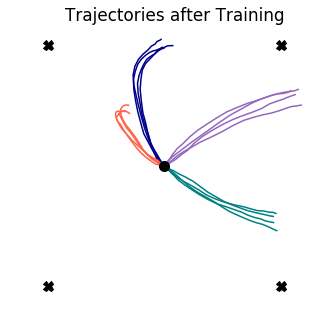

In [27]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])
